In [1]:
import re
import torch
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import platform
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from sklearn.model_selection import KFold

# Dropout
Dropout을 적용하고 싶은 레이어 전에 Dropout을 넣어줘야 함<br>
train시에는 꺼지지 않은 값이 2배가 됨

In [3]:
x = torch.Tensor([[1,2,3,4], [4,5,6,7]])
nn.Dropout(0.5).forward(x)

tensor([[ 2.,  0.,  6.,  8.],
        [ 8., 10.,  0.,  0.]])

# nn.CrossEntropyLoss()
logsoftmax + nllloss이기 때문에 모델 안에 softmax레이어를 넣을 필요 없음<br>
target은 long이어야 하고 input은 데이터 개수 x output_dim(=카테고리개수)여야 함<br>
output은 데이터개수 차원이고 안의 내용은 카테고리 숫자여야함 <br>

In [4]:
>>> loss = nn.CrossEntropyLoss()
>>> input = torch.randn(3, 5, requires_grad=True)
>>> target = torch.empty(3, dtype=torch.long).random_(5)
>>> output = loss(input, target)
>>> output.backward()

In [5]:
target.shape, input.shape

(torch.Size([3]), torch.Size([3, 5]))

# inplace operation

In [6]:
x.add_(1)
x

tensor([[2., 3., 4., 5.],
        [5., 6., 7., 8.]])

# repeat

In [7]:
>>> x = torch.tensor([1, 2, 3])
>>> x.repeat(4, 2)

tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]])

# bmm
Performs a batch matrix-matrix product of matrices stored in input and mat2.

input and mat2 must be 3-D tensors each containing the same number of matrices.

In [8]:
>>> input = torch.randn(10, 3, 4)
>>> mat2 = torch.randn(10, 4, 5)
>>> res = torch.bmm(input, mat2)
>>> res.size()
torch.Size([10, 3, 5])

torch.Size([10, 3, 5])

# sentence_bleu

In [9]:
from sacrebleu import sentence_bleu

In [17]:
sentence_bleu(['i love you'], ['i kill you'])

BLEU = 34.67 66.7/25.0/25.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 3 ref_len = 3)

# maxout

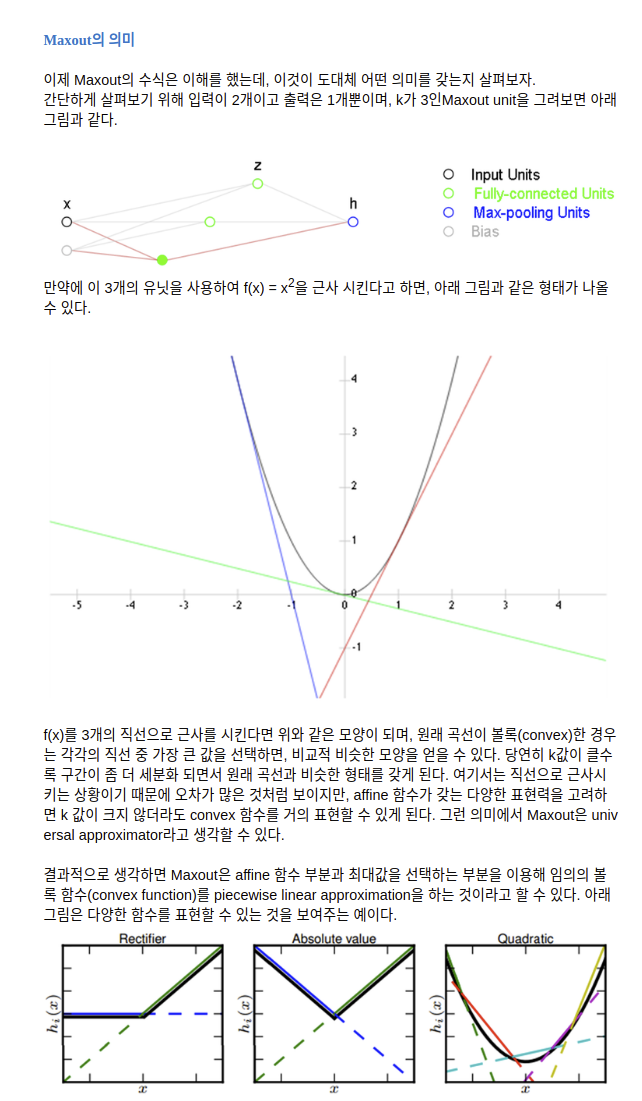

In [1]:
from torch import nn
from torch.nn import MSELoss
import torch
import matplotlib.pyplot as plt

## 2차함수를 근사하는 FCN을 만들어보자 

In [46]:
class fcn(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, src):
        output = self.i2h(src) # [batch size, hidden_size]
        output = self.relu(output)
        output = self.h2o(output)
        return output

In [47]:
input_dim = 1
hidden_dim_m = 50
hidden_dim_k = 40
batch_size = 1000
output_dim = 1

In [48]:
model = fcn(input_dim, hidden_dim_m * hidden_dim_k, output_dim)
loss = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

In [49]:
device = 'cuda'
model.to(device)

fcn(
  (i2h): Linear(in_features=1, out_features=2000, bias=True)
  (relu): ReLU()
  (h2o): Linear(in_features=2000, out_features=1, bias=True)
)

In [50]:
output_list = []
for _ in range(100000):
    optim.zero_grad()
    x = torch.FloatTensor(batch_size, input_dim).uniform_(-30, 30) # batch size, input_dim
    y = x ** 2
    x = x.to(device)
    y = y.to(device)
    output = loss(model(x), y)
    if _ % 200 == 0:
        output_list.append(output)
    output.backward()
    optim.step()

In [51]:
model.eval()
with torch.no_grad():
    xx = torch.range(-20, 20, 1)
    print(xx.shape, xx.unsqueeze(1).shape)
    yy = model(xx.unsqueeze(1).to(device))
    print(yy.shape)

torch.Size([41]) torch.Size([41, 1])
torch.Size([41, 1])


/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  This is separate from the ipykernel package so we can avoid doing imports until


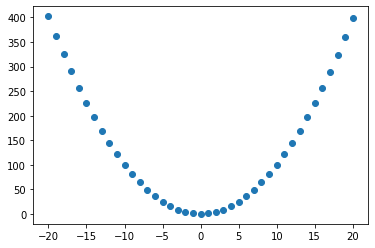

In [52]:
plt.scatter(xx, yy.data.cpu())

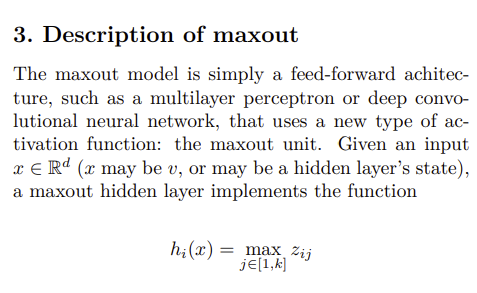

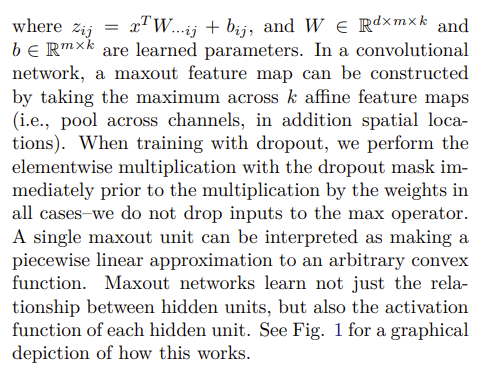

In [2]:
class Maxout(nn.Module):

    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in, self.d_out, self.pool_size = d_in, d_out, pool_size
        self.lin = nn.Linear(d_in, d_out * pool_size)

    def forward(self, inputs):
        shape = list(inputs.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        max_dim = len(shape) - 1
        out = self.lin(inputs)
        m, i = out.view(*shape).max(max_dim)
        return m

In [3]:
input_dim = 1
hidden_dim = 50
batch_size = 1000
output_dim = 1

In [4]:
model = Maxout(input_dim, output_dim, pool_size=hidden_dim)
loss = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [5]:
device = 'cuda'

In [6]:
model.to(device)

Maxout(
  (lin): Linear(in_features=1, out_features=50, bias=True)
)

In [7]:
x = torch.Tensor(2,3,4)
torch.max(x, dim=1).values

tensor([[1.8395e+25, 6.1963e-04, 2.1510e+23, 1.2849e+31],
        [4.3605e+27, 3.0881e+29, 1.1260e+24, 7.1856e+22]])

In [8]:
output_list = []
for _ in range(100000):
    optim.zero_grad()
    x = torch.FloatTensor(batch_size, input_dim).uniform_(-30, 30) # batch size, input_dim
    y = x ** 2
    x, y = x.to(device), y.to(device)
    output = loss(model(x), y)
    if _ % 20 == 0:
        output_list.append(output)
    output.backward()
    optim.step()

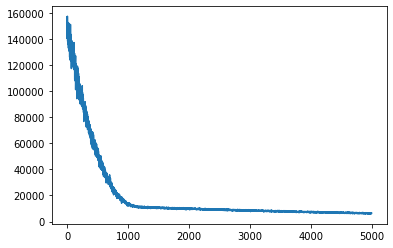

In [10]:
plt.plot(output_list)

In [14]:
# xx

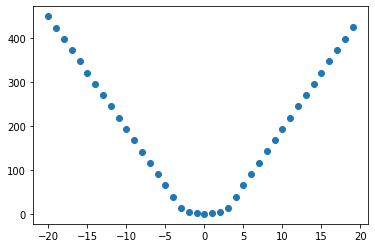

In [24]:
model.eval()
with torch.no_grad():
    xx = torch.arange(-20, 20).type(torch.float32).unsqueeze_(1)
    yy = model(xx.to(device))
    plt.scatter(xx, yy.data.cpu())